# Document Clustering by Topic

This notebook's aim is to cluster documents based on features gathered from tf-idf vectorization. This is done by first cleaning the text, vectorizing tf-idf the content, and then using k-mean to discover the topics of the corpus. Finally, we will use Multidimensional Scaling to convert the maxtrix into a form where we can then visualize the clustering. 

## Library and Resources used

-  Python 3
-  Natural Language Toolkit 
-  Panda
-  Numpy
-  Scikit-learn (Machine Learning in Python)
-  SciPy (Open-source Software for Mathematics, Science, and Engineering)
-  Matplotlib (Plotting)

## Note:

For installation of the nessesary resources and libraries refer to their respective home page for installation steps for your operation system.

In this tutorial we will be using novels gather from Gutenberg. It is important to note that the novels being used are exclusively from Arthur Conan Doyle, Jane Austen, and Charles Dickens. 

Also, the novels have some cleaning done to them. This involes removing the additional notes made by Gutenberg (inlcuding trademarks, notes about the book, branding) from the start and end of each novel.

This Notebook is based on and expands upon a pre-existing IPython Notebook https://github.com/brandomr/document_cluster

This Notebook is also similar to "Document Clustering by Topic using K-Means and PCA" as they share the exact same code until we attempt to visualize the results of the clustering.

### Importing the requried libaries

In [1]:
# Importing base libraries
import re
import os
import codecs
import glob
from __future__ import print_function

# Import nltk
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag

# Import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import Sklearn
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.externals import joblib
from scipy.cluster.hierarchy import ward, dendrogram

# Import Remaining libaries
import numpy as np
import pandas as pd

# Ensure we can see plots inside Jupyter notebook
%matplotlib inline

### Gathering Text from Novels

The first step is to collect the names of each novel and their content. This is done by going through all the texts in the "Novels" folder. It is important to note that the order in which we save both the novel's content and name is synchronized.

In [2]:
# Set path to the file with novels
path = "./Novels"

# Save all the titles of the texts
textName = []

# Save all the content of the texts
textContent = []

# Go to the directory with all the text files
for filename in os.listdir(path):
    
    # Add the file name and remove the file type (in this case ".txt")
    textName.append(filename[:-4])
    
    # Open each file and add all the content 
    with open(path + '/' + filename, encoding="utf-8", mode="r") as file:
         fileContent = file.read()

    # Add the content of the file
    textContent.append(fileContent)

### Checkpoint

This is just to double check that we have an equal amount of titles to content.

In [3]:
#Check the amount of text being analyzed equals the amount of text titles we recorded
if len(textName) == len(textContent):
    print("The amount of text titles matches the amount of text content")
else:
    print("Amount of content and titles do not match")

The amount of text titles matches the amount of text content


### Cleaning the Text

Now we begin cleaning the texts, in addition to the pre-cleaning as mentioned before. We first must define some cleaning tools.

The first being stopwords. The second is stemming words. This means "happening", and "happened" are converted to the same root word, "happen".

In [4]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# Use snowballer to break words into their roots
stemmer = SnowballStemmer("english", ignore_stopwords=False)

### Defining Cleaning Function

Given that there is going to be a lot of cleaning done in this tutorial, I wrote them into their own functions. 

In [5]:
# Tokenize text 
def tokenize_Text(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    return tokens

# Remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

# Takes tokenized text and removes all proper nouns with nltk tags
def strip_properNouns(token):
    # Break down each word into thier category for tags
    tags = pos_tag(token)
    
    # Remove all the words with the proper noun tags or possessives or proper noun purals
    # You can alter this to remove more tags (search for nltk tag for more options)
    removedProperNoun = [word for word,pos in tags if pos != 'NNP' and pos != 'POS' and pos != 'NNPS']
    
    return removedProperNoun

# Tokenize and stem is used to break each token down into their base components. This is done to make it simpler 
# on the algorithm later
def token_stem(tokens):
    
    stems = [stemmer.stem(t) for t in tokens]
    return stems

# This filters all non-words out and changes contractions
def filter_word(tokens):
    
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            
            # Check for common contractions and remove them
            # You can add additional cleaning methods here as well
            if token[0] == "\'" or token == "wo" or token == "n't":
                filtered_tokens.append(remove_Contractions(token))
            else:
                filtered_tokens.append(token)
            
    return filtered_tokens

# Remove some common contractions
def remove_Contractions(token):
    
    # Replace contraction with their english word counter part
    return token.replace("wo", "will").replace("n't", "not") \
    .replace("'s", "is").replace("'m", "am") \
    .replace("'ll", "will").replace("'d", "would") \
    .replace("'re", "are").replace("'ve", "have")

### Calling all the Cleaning Functions

Now that there exists a wide variety of cleaning functions to use it is easier to just call one function. It is here that you can choose what additional cleaning functions you would like to add or remove.

In [6]:
# Define a function that calls all the functions I want
def full_clean(text):
    # This can change depending on your needs
    return token_stem(remove_stopwords(filter_word(strip_properNouns(tokenize_Text(text)))))

# Define this function to just not include the stemming phase
# The reason for this is explained later
def full_clean_without_stem(text):
     return remove_stopwords(filter_word(strip_properNouns(tokenize_Text(text))))

### Check point

This is to check to see if your cleaning works as intended. It is useful to check to see if your cleaning works ahead of time, since depending on your corpora this may take a while to process. It is better to know now than later if your cleaning method works.

Note: If you do not like some aspects of the cleaning presented, feel free to remove them in the "full_clean" and "full_clean_without_stem" functions above and test the results with some samples below.

In [7]:
# Testing Full clean
test_1 = full_clean("Did proper nouns get removed Jimmy?")
test_2 = full_clean("Do I remove the number 5 from my list?")
test_3 = full_clean("Plurals? like what happens with multiples")
test_4 = full_clean("What happens to won't, don't, didn't?")
test_5 = full_clean("Is Jimmy one of those happening, happened, or happen")

# Printing test
print(test_1)
print(test_2)
print(test_3)
print(test_4)
print(test_5)

['proper', 'noun', 'get', 'remov']
['do', 'i', 'remov', 'number', 'list']
['plural', 'like', 'happen', 'multipl']
['what', 'happen']
['is', 'one', 'happen', 'happen', 'happen']


It is important to note that words such as "remove" became "remov". This is because of the nltk stemming package. Later on in the notebook we will create a parallel list that contains the original. Therefore when we convert it back it will return to its spelling in the text. In this example "remove". If you are curious on what words get removed where, feel free to experiment with each function.

### Applying the Cleaning to the Text

Now that we have the cleaning function, we are going to clean all the text. First we are going to have two parallel lists. One that has the original word and another with the stemmed version. This is to reduce the variation of words in the text for analysis. We keep the original word so we can convert them back later. 

In [9]:
# Create two separate lists to hold one with tokenized words and the other with stemmed versions of those words
text_stemmed = []
text_tokenized = []

# Iterate through all the text
for work in textContent:

    # Store the text that has been stemmed into text stemmed
    alltext_stemmed = full_clean(work)
    text_stemmed.extend(alltext_stemmed)
    
    # Store all the text that has not been stemmed into text tokenized
    alltext_tokenized = full_clean_without_stem(work)
    text_tokenized.extend(alltext_tokenized)

### Quick Check
Lets check the first 10 words in both lists and see if they make sense.

In [10]:
print(text_stemmed[:10])
print(text_tokenized[:10])

['i', 'have', 'endeavour', 'littl', 'book', 'rais', 'shall', 'put', 'reader', 'humour']
['I', 'HAVE', 'endeavoured', 'little', 'book', 'raise', 'shall', 'put', 'readers', 'humour']


Feel free to do additional cleaning on the resulting list afterwards. In this example "the" reappears. This is because the cleaning process does not remove "the" if it appears at the start of the sentence. 

Remember that any additional cleaning done here should be mirrored in both lists. This is to ensure that both lists are the same length and the words line up in their index. If they do not it will cause errors later on.

### Converting to Panda Dataframe

Now that we have the list it is time to put them into a panda dataframe. Panda is tool that helps with data analysis and manipulation. To find out more see their website: https://pandas.pydata.org/ 

In [11]:
# Create a panda dataframe that has stemmed words as index and tokenized words as columns
# This is so that words like "happened, happening" are all mapped to the same index "happen"
vocab_frame = pd.DataFrame({'words': text_tokenized}, index = text_stemmed)

In [12]:
# As you can see the stem words (on the left) matches their original word (right)
vocab_frame[:10]

,words
i,I
have,HAVE
endeavour,endeavoured
littl,little
book,book
rais,raise
shall,shall
put,put
reader,readers
humour,humour


### TF-IDF Vectorizer

TF-IDF stands for term frequency–inverse document frequency. It is a statistic that tries to determine how important a word is to a document in a collection or corpus.

To find out a bit more detail on TF-IDF, see their wikipedia page (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

The Vectorizer converts the raw data into TF-IDF features. To find out more visit sklearn page (http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [13]:
# max_df: max cut off for how frequent a term appears in the collection 
# If it is too frequent it probably holds little meaning

# min_df: min start point to be considered a feature
# If it appears too infrequently it is probably doesn't have enough importance.

# max_features: maximum amount of features that can exist

# Tokenizer: gave the previously defined cleaner

# ngram_range: Declare that I want to look at unigrams, bigrams and trigrams

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, 
                                 use_idf=True, tokenizer=full_clean, ngram_range=(1,3))

# Fit the vectorizer to the textContent
tfidf_matrix = tfidf_vectorizer.fit_transform(textContent)

# See the shape of the vector
print(tfidf_matrix.shape)

(24, 33215)


### Acquring Feature Names

Now it is time to acquire the terms in the tfidf matrix.

In [14]:
# Save all the terms from vectorizer into a variable to be used later
terms = tfidf_vectorizer.get_feature_names()

### Using Cosine Similarity 

Now that we have all features and tf-idf of each document it is time to compute the similarity. This is done using cosine similarity which calculates the similarity of a normalized dot product of X and Y. The reason we have 1 subtract the similarity is because we are plotting on a euclidean (2-dimensional) plane.

In [15]:
# Calculate cosine similarity on the tf-idf matrix
dist = 1 - cosine_similarity(tfidf_matrix)

### Clustering with K-means 

Now that we have the similarities we are going to cluster the documents using K-means.
K-means first asks for a number of clusters. You can have more or less, in this example there is 5. Now K-means attempts to cluster the document into 5 clusters. The process may take a while.

To find out more (https://en.wikipedia.org/wiki/K-means_clustering)

In [16]:
# Declare amount of clusters
num_clusters = 5

# Initalize KMeans with the amount of clusters declared
km = KMeans(n_clusters=num_clusters)

# Run Kmeans on the matrix
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
# Get the cluster that each document belongs to into a list
clusters = km.labels_.tolist()

### Setting The Results For Plotting 

Now that we have all our results we begin to structure it into a format we can display.

In [18]:
# Set the book dictionary to hold the book's title, content, and cluster it belongs to
books = { 'title': textName, 'content': textContent, 'cluster': clusters }

# Set the panda dataframe
# Data is the content of the dictionary
# Index is the clusters
# Columns as the keys of the dictionary
resultFrame = pd.DataFrame(books, index = [clusters] , columns = ['title', 'cluster', 'content'])

In [19]:
# What the dataframe looks like
resultFrame

,title,cluster,content
3,A Christmas Carol,3,﻿\n\nPREFACE\n\nI HAVE endeavoured in this Gho...
2,A Study In Scarlet,2,A STUDY IN SCARLET.\n\n\n\n\n\nPART I.\n\n(_Be...
0,A Tale of Two Cities,0,﻿\n\nCONTENTS\n\n\n Book the First--Recall...
3,Bleak House,3,﻿\nCONTENTS\n\n Preface\n I...
3,David Copperfield,3,﻿\nCONTENTS\n\n\n I. I Am Born\n ...
3,Emma,3,﻿\n\nVOLUME I\n\n\n\nCHAPTER I\n\n\nEmma Woodh...
3,Great Expectations,3,﻿\nChapter I\n\nMy father’s family name being ...
1,Lady Susan,1,﻿\n\nI\n\n\nLADY SUSAN VERNON TO MR. VERNON\n\...
3,Mansfield Park,3,﻿CHAPTER I\n\nAbout thirty years ago Miss Mari...
1,Northanger Abbey,1,﻿CHAPTER 1\n\n\nNo one who had ever seen Cathe...


In [20]:
# Have a look at how many documents are in each cluster
resultFrame['cluster'].value_counts()

3    11
2     6
1     3
4     2
0     2
Name: cluster, dtype: int64

### Looking At the Results

Before we plot lets have a more detailed look at what documents are in each category and what features that each cluster contains.

In [21]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
order_centroids[:, :8]

array([[15872,  6825, 17751, 15903,  4056, 25508, 20381,  7580],
       [ 3420,  6920, 27339, 13263, 13262, 13297,  5578, 11909],
       [12043, 31004, 23698, 25155, 25156, 18005, 14521, 18331],
       [23758, 13289,  6979,  8269,   788,  1482, 23929, 19764],
       [21796,  3545,  6541, 12519, 12915,  3445, 17866,  3214]], dtype=int64)

In [22]:
len(vocab_frame)
#vocab_frame['russel']

1627104

In [23]:
print("Top terms per cluster: \n")

# Cluster the centers by how close they are to the centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

# Store the clustered terms
clusterTerm = []

# For the amount of clusters
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    term = ''
    # Get the top 6 words index in each cluster 
    for ind in order_centroids[i, :6]:
        
        # Search the vocab_frame (the dictionary with the original non-stem words)
        # Save that into title
        title = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]
        
        # Try printing the title
        try:
            print(" " + title + ",")
            term = term + title + ", "
        # If it is unable to print the word found at the index 
        except:
            print(" " + vocab_frame.index[ind] + ",")
            term = term + vocab_frame.index[ind] + ", "

    # Begin printing the titles of each cluster
    print("\n")
    print("Cluster %d titles:" % i, end='')

    # Print all the titles 
    try:
        for title in resultFrame.ix[i]['title'].values.tolist():
            print(' %s,' % title, end='')
    except:
        print (' %s' % resultFrame.ix[i]['title'], end = '')
        
    # Append the terms (this is to be used later when we display words of each cluster)
    clusterTerm.append(term)
    print("\n")

Top terms per cluster: 

Cluster 0 words:

C:\Users\zoonl\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


 Lucie,
 spanish,
 monsieur,
 madame,
 colonel,
 sir,


Cluster 0 titles: A Tale of Two Cities, Sense and Sensibility,

Cluster 1 words:

C:\Users\zoonl\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


 Catherine,
 Elizabeth,
 seal,
 Jane,
 ask,
 i,


Cluster 1 titles: Lady Susan, Northanger Abbey, Pride and Prejudice,

Cluster 2 words: Holmes,
 death,
 said,
 face,
 face,
 ring,


Cluster 2 titles: A Study In Scarlet, The Adventures of Sherlock Holmes, The Hound of the Baskervilles, The Return of Sherlock Holmes, The Sign of the Four, The Valley of Fear,

Cluster 3 words: said,
 Joe,
 Emma,
 Fanny,
 Anne,
 aunts,


Cluster 3 titles: A Christmas Carol, Bleak House, David Copperfield, Emma, Great Expectations, Mansfield Park, Oliver Twist, Our Mutual Friend, Persuasion, The Life And Adventure Of Nicholas Nickleby, The Pickwick Papers,

Cluster 4 words: professor,
 challenge,
 never,
 huge,
 Indian,
 cave,


Cluster 4 titles: Tales of Terror and Mystery, The Lost World,



# Multidimensional Scaling (MDS)

There are different choices out there to convert the distance matric into a 2-D array. Therefore, this notebook will look at Multidimensional Scaling (MDS) for converting the distance matric. 

MDS can be considered an alternative to factor analysis  In general, the goal of the analysis is to detect meaningful, underlying dimensions to explain the observed distances between the investigated objects.

To find out more on either, see their respective links: https://en.wikipedia.org/wiki/Multidimensional_scaling 

In [24]:
# Initialize MSD
MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# Fit the model to the distance matrix
pos = mds.fit_transform(dist)  

# Save the results
MSDxs, MSDys = pos[:, 0], pos[:, 1]

# Setting up Graph Information

Now that we have completed the data gathering and process portion, we will move onto declaring some variables to graph. The first step is to set up colours to separate the categories and their names.

In [25]:
# Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4:'#ff0000'}

cluster_names = {}

# Set up cluster names using a dict
cluster_names = {0: clusterTerm[0], 
                 1: clusterTerm[1], 
                 2: clusterTerm[2], 
                 3: clusterTerm[3], 
                 4: clusterTerm[4]}

# Producing Graph

Since we have converted the distance using two different metrics (MSD and PCA) we are going to create a new function that is going to plot both.

In [26]:
def create_graph(xs, ys):

    # Create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=textName)) 

    # Group by cluster
    groups = df.groupby('label')

    # Set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size

    # Iterate through groups to layer the plot
    # Note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',         # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',        # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

     # Show legend with only 1 point
    ax.legend(numpoints=1)

    # Add label to x, y position for the book titles 
    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    # Display graph
    plt.show()

    # If you want to save the plot created uncomment the line below and replace "_insertName_" with a filename 
    #plt.savefig('_insertName_.png', dpi=200)

# Graphing MDS

C:\Users\zoonl\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


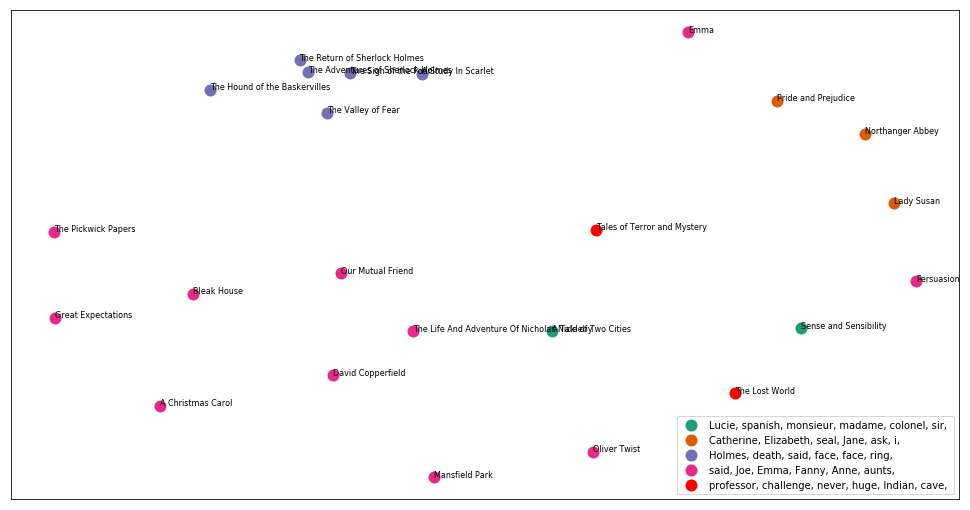

In [27]:
# Graph MSD
create_graph(MSDxs,MSDys)

# Graph with A Dendrogram

We could also gain additonal insight into the clusters by graphing the results from our distance matrix on a dendrogram.

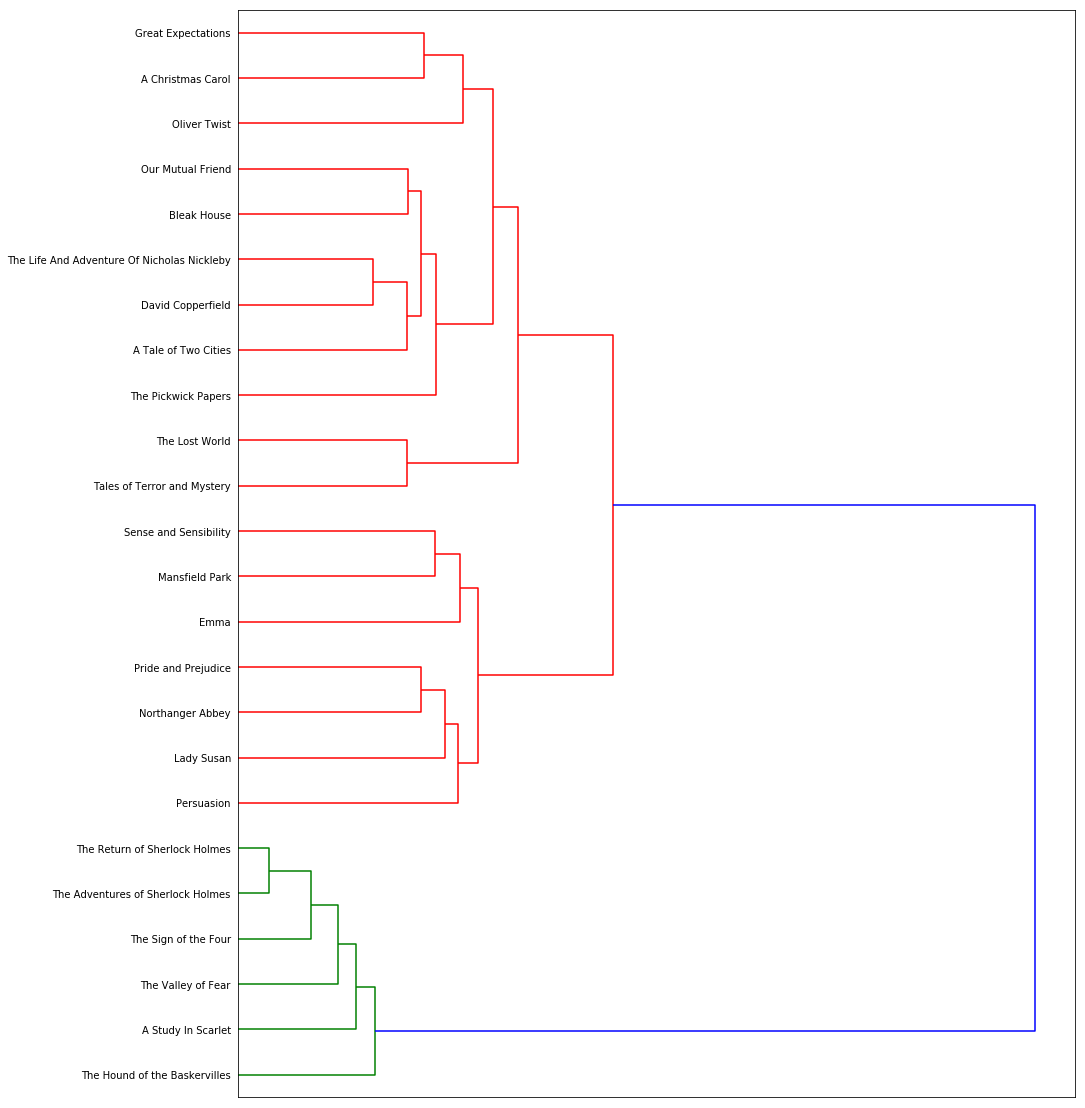

In [28]:
# Define a linkage_matrix using ward clustering pre-computed distances
linkage_matrix = ward(dist) 

# Set size of the graph
fig, ax = plt.subplots(figsize=(15, 20))

# Set the graph type and other labels
ax = dendrogram(linkage_matrix, orientation="right", labels=textName);

plt.tick_params(
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

# Display Matrix
plt.show()

# To save figure, uncomment the line below and replace "_insertName_" with the filename
#plt.savefig('_insertName'.png', dpi=200) 

# Conclusion

This notebook went over a couple of different topics. How to clean a text, clustering the documents based on tf-idf, and finally using MSD to visualize how related they are with each.

This Notebook was created, modified, and expanded from Brandon IPython Notebook. They can be found here:
https://github.com/brandomr/document_cluster and
http://brandonrose.org/clustering 